# Edgotyping matrices

Matrix showing whether a protein's interactions are still observed in for different alleles of the corresponding gene. 

In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd


%matplotlib inline
pd.set_option('display.max_columns', 50)

In [2]:

df = pd.read_csv('../data/processed/Supplementary Table 17.txt', sep='\t')
# Choose highest growth score in cases where multiple
# assay versions were tested.
df = (df.sort_values(['GS_WT', 'assay_id'], 
                     ascending=[False, True])
        .drop_duplicates(['interactor_orf_id', 'causal_orf_id', 'causal_mut_id']))
df['tis_spec_partner'] = (df['interactor_tis_expr'] > 5.) & (df['interactor_TiP_expr'] >= 2.)
# drop partners where wildtype is growth score 1 since,
# by our definition of growth score difference ≥ 2, we can't observe pertubation
df = df.loc[(df['GS_WT'] > 1) | (df['GS_WT'].isnull()), :]
# at least half of the interactors tests didn't fail
gt_half_success = (df.groupby(['CG_symbol', 'causal_mut_id'])  # groupby interactors
                     ['perturbed']
                     .transform(lambda x: (x.notnull().sum() / x.shape[0]) >= 0.5))
df = df.loc[gt_half_success | (df['causal_mut_id'] == 0), :]
df['uncertain/benign'] = ~df['pathogenecity'].str.match('Pathogenic|Likely pathogenic|risk factor|WT')

In [3]:
df.head(20)

,causal_gene_id,CG_symbol,causal_orf_id,causal_mut_id,interactor_gene_id,interactor_symbol,interactor_orf_id,assay_id,GS_WT,GS_allele,GS_diff,perturbed,final_score,mutation,pathogenecity,omim_ids,TiP_tissue,CG_tis_expr,CG_TiP_expr,interactor_tis_expr,interactor_TiP_expr,tis_spec_partner,uncertain/benign
1,ENSG00000136143,SUCLA2,1598,0,ENSG00000170540,ARL6IP1,2374,1,4.0,NaN,NaN,NaN,1,NaN,WT,612073,brain-0,11.43040,0.576914,14.09000,2.172370,True,False
3,ENSG00000136143,SUCLA2,1598,0,ENSG00000177674,AGTRAP,7845,1,4.0,NaN,NaN,NaN,1,NaN,WT,612073,brain-0,11.43040,0.576914,9.16467,-1.045780,False,False
9,ENSG00000136143,SUCLA2,1598,214053,ENSG00000177674,AGTRAP,7845,1,4.0,0.0,4.0,1.0,0,Gly118Arg,Pathogenic,612073,brain-0,11.43040,0.576914,9.16467,-1.045780,False,False
11,ENSG00000136143,SUCLA2,1598,214053,ENSG00000170540,ARL6IP1,2374,1,4.0,0.0,4.0,1.0,0,Gly118Arg,Pathogenic,612073,brain-0,11.43040,0.576914,14.09000,2.172370,True,False
15,ENSG00000136143,SUCLA2,1598,214054,ENSG00000170540,ARL6IP1,2374,1,4.0,0.0,4.0,1.0,0,Asp251Asn,Pathogenic,612073,brain-0,11.43040,0.576914,14.09000,2.172370,True,False
17,ENSG00000136143,SUCLA2,1598,214054,ENSG00000177674,AGTRAP,7845,1,4.0,0.0,4.0,1.0,0,Asp251Asn,Pathogenic,612073,brain-0,11.43040,0.576914,9.16467,-1.045780,False,False
109,ENSG00000108433,GOSR2,3086,0,ENSG00000106089,STX1A,12260,1,4.0,NaN,NaN,NaN,1,NaN,WT,614018,brain-1,6.00752,-0.743531,12.55950,2.502100,True,False
110,ENSG00000108433,GOSR2,3086,0,ENSG00000103496,STX4,8013,1,4.0,NaN,NaN,NaN,1,NaN,WT,614018,brain-1,6.00752,-0.743531,10.51250,-1.061070,False,False
146,ENSG00000108433,GOSR2,3086,201084,ENSG00000103496,STX4,8013,1,4.0,4.0,0.0,0.0,1,Gly144Trp,Pathogenic,614018,brain-1,6.00752,-0.743531,10.51250,-1.061070,False,False
147,ENSG00000108433,GOSR2,3086,201084,ENSG00000106089,STX1A,12260,1,4.0,3.0,1.0,0.0,1,Gly144Trp,Pathogenic,614018,brain-1,6.00752,-0.743531,12.55950,2.502100,True,False


In [7]:
def edgotype_results_plot(df, box_size=300, ax=None):
    """Visualize pairwise test results with boxes: empty box for negative,
    filled box for positive and missing box for missing values.
    
    You need to manually tune the box_size and figure size to get it to look good.
    
    Args:
        df (pandas.DataFrame): boolean values for whether an interaction was detected
        box_size (int): area of the boxes in points
        ax (matplotlib.axes.Axes)
    
    """
    if ax is None:
        ax = plt.gca()
    not_null = [(i, j) for i in range(df.shape[1]) for j in range(df.shape[0]) if df.notnull().iloc[j, i]]
    interacts = [(i, j) for i in range(df.shape[1]) for j in range(df.shape[0]) if df.iloc[j, i] and df.notnull().iloc[j, i]]
    ax.scatter([xy[0] for xy in not_null],
               [xy[1] for xy in not_null],
               s=box_size,
               marker='s',
               facecolors='none',
               edgecolors='black')
    ax.scatter([xy[0] for xy in interacts],
               [xy[1] for xy in interacts],
               s=box_size,
               marker='s',
               facecolors='black',
               edgecolors='black')
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.tick_top()
    ax.set_xticks(range(df.shape[1]))
    ax.xaxis.set_tick_params(length=0)
    ax.xaxis.set_ticklabels(df.columns, rotation=40, ha='left')
    ax.set_yticks(range(df.shape[0]))
    ax.yaxis.set_tick_params(length=0)
    ax.set_yticklabels(df.index)
    ax.set_ylim((-0.5, df.shape[0] - 0.5))
    ax.set_xlim((-0.5, df.shape[1] - 0.5))
    ax.invert_yaxis()

    
def single_gene_results(gene_name,
                        show_non_expressed=True,
                        color_interactors={},
                        fig_dir='../figures',
                        file_suffix='_edgotype_matrix'):
    """For a given gene, tested as a DB with different allelles, plot the edgotyping results.
    
    Only shows interactions where the wildtype is positive.
    
    Args:
        gene_name (str): HGNC symbol
        color_pathogenic: color the pathogenic mutations red and benign blue
        color_interactors: set(str): which interaction partners to highlight red 
        fig_dir (str): directory to save figures in
        
    """
    pnkp = df.loc[df['CG_symbol'] == gene_name, :].copy()
    pnkp.loc[pnkp['pathogenecity'] == 'WT', 'mutation'] = gene_name + ' WT'
    pnkp.loc[pnkp['pathogenecity'] == 'WT', 'perturbed'] = 0.
    pnkp = pnkp.loc[:, ['mutation', 'interactor_symbol', 'perturbed']]
    pnkp = pnkp.pivot(index='mutation',
                      columns='interactor_symbol',
                      values='perturbed')
    # the data is string of '0'/'1' with missing values
    pnkp = pnkp.applymap(lambda x: bool(1. - x) if pd.notnull(x) else np.NaN)
    pnkp = pnkp.loc[:, pnkp.loc[gene_name + ' WT', :] == True]
    if pnkp.shape[0] < 2 or pnkp.shape[1] < 1:
        return
    
    def get_aa_pos(s):
        if s.endswith('WT'):
            return -999999
        elif s == '????????':
            return 999999999
        else:
            return int(s[3:-3])
    
    pnkp['aa_pos'] = pnkp.index.map(get_aa_pos)
    pnkp = pnkp.loc[pnkp['aa_pos'] != 1, :] # remove mutations that change start codon
    pnkp = pnkp.sort_values(by='aa_pos').drop(columns='aa_pos')
    under_expressed_interactors = set(df.loc[(df['CG_symbol'] == gene_name) &
                                         ((df['interactor_tis_expr'] <= 5) |
                                          df['interactor_tis_expr'].isnull()),
                                         'interactor_symbol'].unique())
    if not show_non_expressed:
        pnkp = pnkp.loc[:, ~pnkp.columns.isin(under_expressed_interactors)]
    plt.clf()
    fig, ax = plt.subplots(1, 1)
    ylabel_size_inches = 1.4
    xlabel_size_inches = 0.9
    box_space_inches = 0.35 # tuned these three numbers by trial and error
    fig.set_size_inches(ylabel_size_inches + pnkp.shape[1] * box_space_inches,
                        xlabel_size_inches + pnkp.shape[0] * box_space_inches)
    edgotype_results_plot(pnkp, box_size=200, ax=ax)
    color_interactors = set(df.loc[(df['CG_symbol'] == gene_name) &
                                   df['tis_spec_partner'],
                                    'interactor_symbol'].unique())
    for xtick in ax.get_xticklabels():
        if xtick.get_text() in color_interactors:
            xtick.set_color('xkcd:green')
            xtick.set_fontweight('bold')
    uncertain_or_benign = set(df.loc[(df['CG_symbol'] == gene_name) &
                                     df['uncertain/benign'],
                                     'mutation'].unique())
    for xtick in ax.get_xticklabels():
        if xtick.get_text() in under_expressed_interactors:
            xtick.set_color('grey')
    for ytick in ax.get_yticklabels():
        if ytick.get_text() in uncertain_or_benign:
            ytick.set_color('grey')
        else:
            ytick.set_color('red')
    plt.tight_layout()
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(os.path.join(fig_dir,
                             gene_name + file_suffix + '.pdf'))

<Figure size 432x288 with 0 Axes>

<Figure size 277.2x140.4 with 0 Axes>

<Figure size 1033.2x115.2 with 0 Axes>

<Figure size 277.2x216 with 0 Axes>

<Figure size 252x115.2 with 0 Axes>

<Figure size 856.8x165.6 with 0 Axes>

<Figure size 831.6x140.4 with 0 Axes>

<Figure size 1033.2x115.2 with 0 Axes>

<Figure size 453.6x115.2 with 0 Axes>

<Figure size 529.2x165.6 with 0 Axes>

<Figure size 554.4x115.2 with 0 Axes>

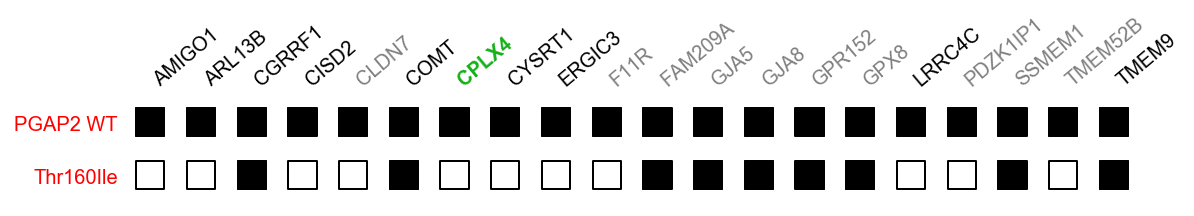

In [5]:
for symbol in df['CG_symbol'].unique():
    single_gene_results(symbol)

<Figure size 432x288 with 0 Axes>

<Figure size 252x140.4 with 0 Axes>

<Figure size 680.4x115.2 with 0 Axes>

<Figure size 176.4x216 with 0 Axes>

<Figure size 252x115.2 with 0 Axes>

<Figure size 655.2x165.6 with 0 Axes>

<Figure size 730.8x140.4 with 0 Axes>

<Figure size 730.8x115.2 with 0 Axes>

<Figure size 302.4x115.2 with 0 Axes>

<Figure size 352.8x165.6 with 0 Axes>

<Figure size 428.4x115.2 with 0 Axes>

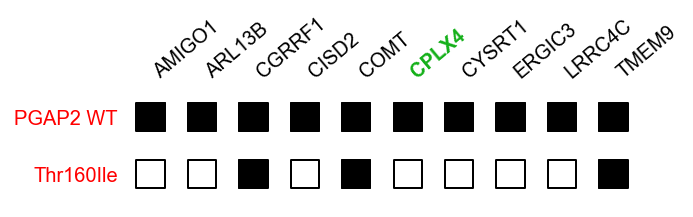

In [8]:
for symbol in df['CG_symbol'].unique():
    single_gene_results(symbol, show_non_expressed=False, file_suffix='_edgotype_matrix_remove_non_expressed')